# Draw insights from Twitter data about car makers


This notebook shows you how to analyze over six million tweets about six popular car makers (Volkswagen, Toyota, Mercedes, BMW, GM, and Tesla) and extract interesting insights from these tweets. You will learn how to find, filter, and sort tweets by engagement, influence, location and sentiment. 

The notebook shows you how to integrate data from dashDB by using a Spark connector. Additionally, you will learn how to easily perform complex computations on a large amount of data by using a SparkContext object, which enables you to start tasks on the Spark cluster. 

This notebook runs on Python 2 with Spark 1.6.

## Table of contents

- [Prepare the data set and data flow](#preparedata)
- [Import libraries](#importlibs)
- [Define global variables and helper functions](#definevars)
- [Acquire data](#acquiredata)
- [Transform data](#transformdata)
- [Determine the distribution of tweets across geographies](#distdatageos)
- [Analyze tweet sentiments and timelines](#analyzesentiment&timeline)
   - [Analyze sentiment](#analyzesentiment&timeline_sentiment)
   - [Analyze timelines](#analyzetimeline)
- [Draw insights from tweets about car manufacturers](#drawinsights)
- [Draw insights about car features](#drawinsightsaboutfeatures)
- [Summary](#summary)


<a id="preparedata"> </a>
## Prepare the data set and data flow

The first step in the analysis process is to harvest the data. You can use the IBM Insights for Twitter API service ([link](https://console.ng.bluemix.net/catalog/services/insights-for-twitter/)) to get Twitter data about Volkswagen, Toyota, Mercedes, BMW, GM, and Tesla to use in this sample.
 
To filter the tweets and return only those that were posted about six leading car manufacturers in 2015, use the following query:  
`'(posted:2015-01-01,2015-12-31) AND (volkswagen OR vw OR toyota OR daimler OR mercedes OR bmw OR gm OR "general motors" OR tesla)'` 

Then warehouse this data into dashDB. You can use an existing dashDB instance or provision a new service.

<a id="importlibs"> </a>
## Import libaries
Run the following cell to install the libraries you will work with in this notebook:

In [1]:
!pip install seaborn --user

You might need to restart the kernel after installing the libraries for the first time on a Spark instance.

Now, run the following cell to import the libraries to the notebook:

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
import time
from datetime import date
from dateutil import parser
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from IPython.core.display import Javascript
from __future__ import division
%matplotlib inline
sqlContext = SQLContext(sc)

<a id="definevars"> </a>
## Define global variables and helper functions

To enable analyzing the content of tweets in this sample notebook, you will use the following global variables:
- The `car_marker_list` variable contains all car manifacturers. Each element in the array is a list with all spelling variants of each manufacturer.
- The `car_makers_name_list` variable contains the most common spelling variant of each car manufacturer.
- The `electric_vehicle_terms` variable contains alternative terms that can be used for electric cars.
- The `auto_driver_terms` variable contains alternative terms that can be used for self-driving cars.

In [3]:
car_makers_list = [['bmw'], ['daimler', 'mercedes'], ['gm', 'general motors'], ['tesla'], ['toyota'], ['vw', 'volkswagen']]
car_makers_name_list = []
for car_maker in car_makers_list:
    car_makers_name_list.append(car_maker[0].upper())
ind = np.arange(len(car_makers_list)) #index list for plotting
width = 0.8       # the width of the bars in the bar plots
num_car_makers = len(car_makers_list)
##car features #supported languages: English, Deutsch, french, Spanish
electric_vehicle_terms = ['electric car', 'electric vehicle', 'electric motor', 'hybrid vehicle', 'Hybrid car', 'elektroauto', 'elektrofahrzeug', 
                          'hybridautos', 'voiture hyprid', 'coche híbrido', 'Auto Hibrido', 'vehículo híbrido', 'elektrovehikel', 'voiture électrique', 'coche eléctrico']
auto_driver_terms = ['auto drive', 'autodrive', 'autonomous', 'driverless', 'self driving', 'robotic', 'autonomes', 'selbstfahrendes', 'autonome', 'autónomo']

The sample uses the following two helper functions called `GeoChart` and `addMissingDates`. 

The `GeoChart` function plots the world map in a DOM element (an iframe).

The `addMissingDates` function checks for any missing dates in the following data structures with time series data:
* The `baseDataframe` DataFrame contains all ofthe dates. It must have the column names [POSTING_TIME, NUM_TWEETS]
* The `checkedDataframe` DataFrame contains the dates that need to be checked. It must have the column names [POSTING_TIME, NUM_TWEETS]

In [4]:
def GeoChart(data_string, element):
    return Javascript("""
        //container.show();
        function draw() {{
          var chart = new google.visualization.GeoChart(document.getElementById(""" + element + """));
          chart.draw(google.visualization.arrayToDataTable(""" + data_string + """));
        }}
        google.load('visualization', '1.0', {'callback': draw, 'packages':['geochart']});
        """, lib="https://www.google.com/jsapi")

def addMissingDates(baseDates, checkedDates):
    temp = checkedDates.copy()
    checkedDatesValues = checkedDates['POSTING_TIME']
    for index, row in baseDates.iterrows():
        if (not row['POSTING_TIME'] in checkedDatesValues.tolist()):
            row['NUM_TWEETS'] = 0
            temp = temp.append(row)
    return temp.sort('POSTING_TIME')

<a id="acquiredata"> </a>
## Acquire data

To access the Twitter data that you added to dashDB, you must provide the dashDB service credentials. The data is retrieved from the database by using the Spark JDBC connector and is loaded into a Spark DataFrame in the notebook called `df_CARS_TWEETS` by using `sqlContext.read.jdbc`. The DataFrame has the same column names as the tweets table in dashDB.

Provide the credentials of your dashDB instance that contains your warehoused Twitter data and run the next cell to load this data.

The code in the next cell reads the credentials and loads the data from dashDB into a DataFrame data structure:

In [5]:
props = {}
props['user'] = ''
props['password'] = ''
jdbcurl = ''
table_name = ''
df_CARS_TWEETS = sqlContext.read.jdbc(jdbcurl, table_name, properties=props)
df_CARS_TWEETS.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_POSTED_TIME: timestamp (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- USER_ID: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_STATE: string (nullable = true)
 |-- USER_COUNTRY: string (nullable = true)
 |-- USER_CITY: string (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_LOCATION: string (nullable = true)
 |-- SENTIMENT: string (nullable = true)
 |-- IS_PARENT: string (nullable = true)
 |-- IS_MARRIED: string (nullable = true)
 |-- USER_FOLLOWERS_NUM: integer (nullable = true)
 |-- USER_FRIENDS_COUNT: integer (nullable = true)



The following code cell counts the number of rows that were loaded into the DataFrame, which is equivalent to the number of tweets available for further processing:

In [6]:
df_CARS_TWEETS.count()

6411106

<a id="transformdata"> </a>
## Transform data

You can't analyze the data that you have just loaded into the data frames the way it is. To be able to consume this data, it must first be prepared and transformed.

The output of the data transformation process is a new Spark DataFrame which has the target structure on which to base the data analysis. This Spark DataFrame called `df_cleaned_tweets` functions as the main data source for all further processing.

Run the next cell to carry out the following transformations on the data:

1) Remove the time from the timestamp values as only the date information is relevant.

2) Change the values in the string columns like user country, state and city to uppercase.

3) Change the tweet posting location information from a string ('pos (42.000 42.000)') to a numeric value represented by the longitude and latitude coordinates. 

You will use the resulting DataFrame (`df_cleaned_tweets`) as the base data source for all further step. 

The sample uses Spark to do all heavy computation. When it is time to plot or collect the results, the returned data is moved from a Spark DataFrame to a pandas DataFrame. A pandas DataFrame is a flexible data structure for data analysis and plotting. 

In [7]:
def getLongitudeLatitude(position):
    parts = str(position).split('(')[1].split(')')[0].split(' ')
    return parts

def getLongitude(row):
    if ((row.MESSAGE_LOCATION is None)):
        return None
    else:
        parts = getLongitudeLatitude(row.MESSAGE_LOCATION)
        lon = float(parts[0])
        return lon

def getLatitude(row):
    if ((row.MESSAGE_LOCATION is None)):
        return None
    else:
        parts = getLongitudeLatitude(row.MESSAGE_LOCATION)
        lon = float(parts[1])
        return lon

def getDateIgnoreTime(row):
    posting_time = parser.parse(str(row.MESSAGE_POSTED_TIME))
    posting_time = posting_time.replace(hour=0, minute=0, second=0, microsecond=0)
    return posting_time

df_cleaned_tweets = sqlContext.createDataFrame(df_CARS_TWEETS.map(lambda row: [row.MESSAGE_ID,
                        getDateIgnoreTime(row),
                        row.MESSAGE_BODY,
                        row.USER_GENDER,
                        unicode(row.USER_STATE).upper(),
                        unicode(row.USER_COUNTRY).upper(),
                        unicode(row.USER_CITY).upper(),
                        row.MESSAGE_LANGUAGE,
                        getLongitude(row),
                        getLatitude(row),
                        row.SENTIMENT,
                        row.IS_PARENT,
                        row.IS_MARRIED,
                        row.USER_FOLLOWERS_NUM,
                        row.USER_FRIENDS_COUNT
                    ]),
                    ['MESSAGE_ID',
                     'POSTING_TIME',
                     'MESSAGE_BODY',
                     'USER_GENDER',
                     'USER_STATE',
                     'USER_COUNTRY',
                     'USER_CITY',
                     'MESSAGE_LANGUAGE',
                     'MESSAGE_LOCATION_LONGITUDE',
                     'MESSAGE_LOCATION_LATITUDE',
                     'SENTIMENT',
                     'IS_PARENT',
                     'IS_MARRIED',
                     'USER_FOLLOWERS_NUM',
                     'USER_FRIENDS_COUNT'
                    ])

df_cleaned_tweets.registerTempTable('CARS2015_TWEETS_CLEANED')
df_cleaned_tweets.cache()
df_cleaned_tweets.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- POSTING_TIME: timestamp (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_STATE: string (nullable = true)
 |-- USER_COUNTRY: string (nullable = true)
 |-- USER_CITY: string (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_LOCATION_LONGITUDE: double (nullable = true)
 |-- MESSAGE_LOCATION_LATITUDE: double (nullable = true)
 |-- SENTIMENT: string (nullable = true)
 |-- IS_PARENT: string (nullable = true)
 |-- IS_MARRIED: string (nullable = true)
 |-- USER_FOLLOWERS_NUM: long (nullable = true)
 |-- USER_FRIENDS_COUNT: long (nullable = true)



<a id="distdatageos"> </a>
## Determine the distribution of tweets across geographies

This section shows you how to extract the countries with the highest number of tweets. To do that, the data is grouped according to the USER_COUNTRY column, and the rows in each group are counted. Then the groups are sorted in descending order.

In [9]:
#group by country
df_cleaned_tweets_countries = df_cleaned_tweets.groupBy('USER_COUNTRY')\
                                .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))\
                                .orderBy('NUM_TWEETS', ascending=False)
df_cleaned_tweets_countries.cache()
df_cleaned_tweets_countries.show(5)

+--------------+----------+
|  USER_COUNTRY|NUM_TWEETS|
+--------------+----------+
|          NONE|   3517221|
| UNITED STATES|    988891|
|UNITED KINGDOM|    230942|
|     INDONESIA|    148418|
|         SPAIN|    128053|
+--------------+----------+



In [10]:
p_df_cleaned_tweets_countries = df_cleaned_tweets_countries.toPandas()
p_df_cleaned_tweets_countries.ix[p_df_cleaned_tweets_countries['USER_COUNTRY'] == 'NONE', 'USER_COUNTRY'] = 'UNKNOWN'

The next cells show you two ways of plotting the countries with the largest number of tweets. Because this data was prepared and transformed, it can be copied into a pandas DataFrame which is used for plotting the results.

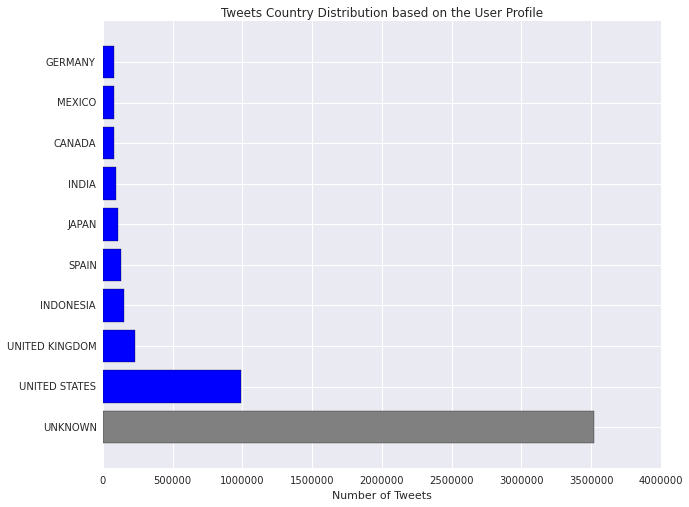

In [11]:
num_plotted_countries = 10
countries = p_df_cleaned_tweets_countries['USER_COUNTRY'][:num_plotted_countries]
num_tweets = p_df_cleaned_tweets_countries['NUM_TWEETS'][:num_plotted_countries]
y_pos = np.arange(len(countries))
colors = np.repeat('b', num_plotted_countries - 1).tolist()
colors = ['gray'] + colors
plt.figure(figsize=(10,8))
plt.barh(y_pos, num_tweets, align='center', color=colors)
plt.yticks(y_pos, countries)
plt.xlabel('Number of Tweets')
plt.title('Tweets Country Distribution based on the User Profile')
plt.ylim(-1, len(y_pos))
plt.show()

In [12]:
%%html
<div id="plot_div" style="width: 900px; height: 500px;"></div>

In [13]:
countries = p_df_cleaned_tweets_countries['USER_COUNTRY']
num_tweets = p_df_cleaned_tweets_countries['NUM_TWEETS']
data = "[['Country', 'Num Tweets']"
index = 0
for country in countries:
    country = country.replace("'", "")
    data = data + ", ['" + country + "', " + str(num_tweets[index]) + "]"
    index += 1
data = data + "]"
GeoChart(data, "'plot_div'")

<IPython.core.display.Javascript object>

Because you won't need the DataFrames related to countries any longer, run the following cell to clear the memory used by those variables (both Spark and pandas):

In [14]:
df_cleaned_tweets_countries.unpersist()
df_cleaned_tweets_countries = None
p_df_cleaned_tweets_countries = None

<a id="analyzesentiment&timeline"> </a>
## Analyze tweet sentiments and timelines

Now learn to find, filter, and sort tweets by sentiment and posting date.

<a id="analyzesentiment&timeline_sentiment"> </a>
###  Analyze sentiment

Analyzing sentiment change and distribution in tweets is one of the most valuable sources of information that the IBM Twitter API provides. By giving each tweet a sentiment value, you can determine whether the content of a tweet is positive, negative, ambivalent, neutral, or NULL (if no value is provided by the API). Unfortunately, a sentiment value is provided for English, German, French, and Spanish tweets only. Because the data set also has tweets in other languages, only a subset of the tweets in the data set have a sentiment value.

The cells in the following section show you how to plot the sentiment values of all tweets in the data set. The tweets are grouped according to their sentiment value. Then the number of tweets in each group is determined.

After you have plotted the results, release the memory of the variables you used.

In [15]:
#get number of tweets with P N U sentiment by grouping the sentiment value
tweets_grouped_by_sentiment = df_cleaned_tweets\
                                    .groupBy('SENTIMENT')\
                                    .agg(F.count('MESSAGE_ID').alias('NUM_TWEETS'))
tweets_grouped_by_sentiment.cache()
tweets_grouped_by_sentiment.show(5)
#move the results to pandas
p_tweets_grouped_by_sentiment = tweets_grouped_by_sentiment.toPandas()

+----------+----------+
| SENTIMENT|NUM_TWEETS|
+----------+----------+
|   NEUTRAL|   3232927|
|AMBIVALENT|     69815|
|  POSITIVE|    810086|
|  NEGATIVE|    348870|
|      null|   1949408|
+----------+----------+



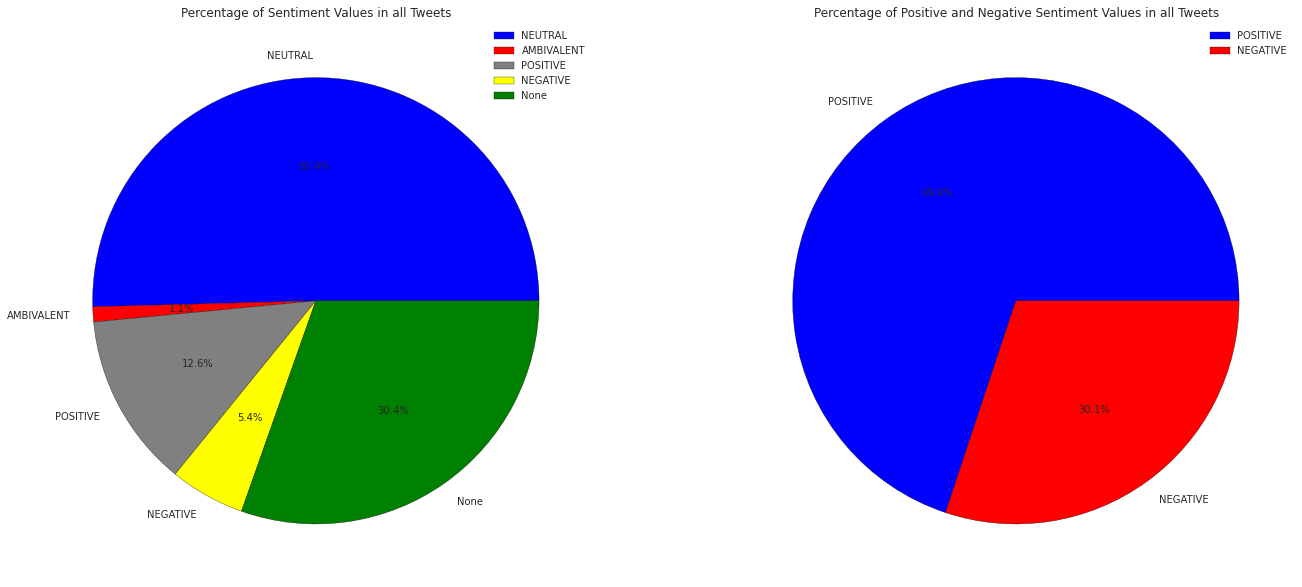

In [16]:
plot1_labels = p_tweets_grouped_by_sentiment['SENTIMENT']
plot1_values = p_tweets_grouped_by_sentiment['NUM_TWEETS']
plot1_colors = ['blue', 'red', 'gray', 'yellow', 'green']
cond1 = (p_tweets_grouped_by_sentiment['SENTIMENT'] == 'POSITIVE')
cond2 = (p_tweets_grouped_by_sentiment['SENTIMENT'] == 'NEGATIVE')
pMessage_sentiment_statistics_defined = p_tweets_grouped_by_sentiment[cond1 | cond2]
plot2_labels = pMessage_sentiment_statistics_defined['SENTIMENT']
plot2_values = pMessage_sentiment_statistics_defined['NUM_TWEETS']
plot2_colors = ['blue', 'red']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))
axes[0].pie(plot1_values,  labels=plot1_labels, colors=plot1_colors, autopct='%1.1f%%')
axes[0].set_title('Percentage of Sentiment Values in all Tweets')
axes[0].set_aspect('equal')
axes[0].legend(loc="upper right", labels=plot1_labels)
axes[1].pie(plot2_values,  labels=plot2_labels, colors=plot2_colors, autopct='%1.1f%%')
axes[1].set_title('Percentage of Positive and Negative Sentiment Values in all Tweets')
axes[1].set_aspect('equal')
axes[1].legend(loc="upper right", labels=plot2_labels)
fig.subplots_adjust(hspace=1)
plt.show()

In [17]:
tweets_grouped_by_sentiment.unpersist()
tweets_grouped_by_sentiment = None
p_tweets_grouped_by_sentiment = None

<a id="analyzetimeline"> </a>
###  Analyze timelines

To learn more about which car manufacturing events occurred in 2015, you can plot data over time. The code cells in the following section group all tweets created in 2015 by their posting date (and their sentiment value) and counts the number of tweets per date.

In [18]:
df_num_tweets_and_sentiment_over_time = df_cleaned_tweets.groupBy('POSTING_TIME', 'SENTIMENT')\
                                    .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))\
                                    .orderBy('POSTING_TIME', ascending=True)
df_num_tweets_over_time = df_num_tweets_and_sentiment_over_time.groupBy('POSTING_TIME')\
                                    .agg(F.sum('NUM_TWEETS').alias('NUM_TWEETS'))\
                                    .orderBy('POSTING_TIME', ascending=True)
p_df_num_tweets_and_sentiment_over_time = df_num_tweets_and_sentiment_over_time.toPandas()
p_df_num_tweets_over_time = df_num_tweets_over_time.toPandas()

Run the next cell to prepare the data for plotting by moving data with different sentiment values into different data frames:

In [19]:
positive_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'POSITIVE'
negative_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'NEGATIVE'
neutral_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'NEUTRAL'
ambivalent_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'AMBIVALENT'
null_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'].isnull()
p_df_num_tweets_and_sentiment_over_time_positive = p_df_num_tweets_and_sentiment_over_time[positive_mask]
p_df_num_tweets_and_sentiment_over_time_negative = p_df_num_tweets_and_sentiment_over_time[negative_mask]
p_df_num_tweets_and_sentiment_over_time_neutral = p_df_num_tweets_and_sentiment_over_time[neutral_mask]
p_df_num_tweets_and_sentiment_over_time_ambivalent = p_df_num_tweets_and_sentiment_over_time[ambivalent_mask]
p_df_num_tweets_and_sentiment_over_time_null = p_df_num_tweets_and_sentiment_over_time[null_mask]
p_df_num_tweets_and_sentiment_over_time_positive = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_positive)
p_df_num_tweets_and_sentiment_over_time_negative = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_negative)
p_df_num_tweets_and_sentiment_over_time_neutral = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_neutral)
p_df_num_tweets_and_sentiment_over_time_ambivalent = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_ambivalent)
p_df_num_tweets_and_sentiment_over_time_null = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_null)

Run the next cell to plot your results after data preparation and transformation. Firstly, you will plot the total number of tweets about Volkswagen, Toyota, BMW, Daimler, Tesla and General Motors spread across 2015. Then you will plot the number of all tweets and the number of tweets with a positive and negative sentiment value. Lastly, you will plot only those tweets that have a sentiment value, be it positive or negative.

After you've completed plotting the results, clear the memory of the variables you used.

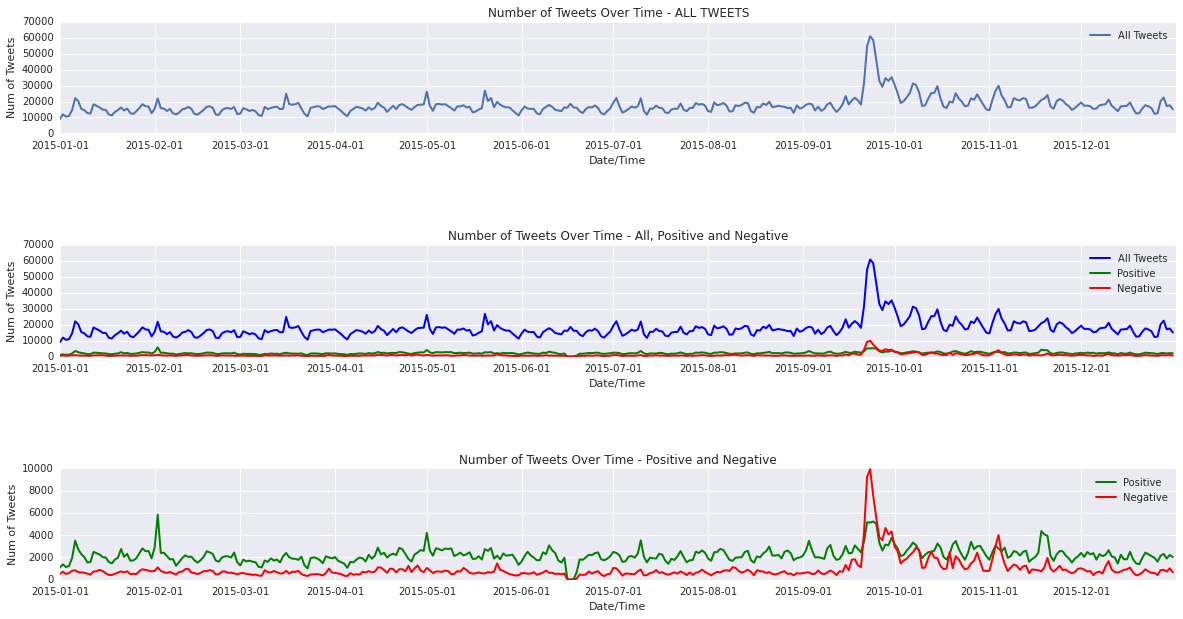

In [20]:
mask_1day = p_df_num_tweets_over_time['POSTING_TIME'].map(lambda x: x.day) == 1
x = p_df_num_tweets_over_time[mask_1day]['POSTING_TIME']
y = p_df_num_tweets_over_time['NUM_TWEETS']
py = p_df_num_tweets_and_sentiment_over_time_positive['NUM_TWEETS']
ny = p_df_num_tweets_and_sentiment_over_time_negative['NUM_TWEETS']
ney = p_df_num_tweets_and_sentiment_over_time_neutral['NUM_TWEETS']
ay = p_df_num_tweets_and_sentiment_over_time_ambivalent['NUM_TWEETS']
nully = p_df_num_tweets_and_sentiment_over_time_null['NUM_TWEETS']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
axes[0].plot(range(len(y)), y, linewidth=2)
axes[0].set_xticks(x.index.tolist())
axes[0].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes[0].margins = 0
axes[0].set_xlabel('Date/Time')
axes[0].set_ylabel('Num of Tweets')
axes[0].set_title('Number of Tweets Over Time - ALL TWEETS')
axes[0].set_xlim(0, len(y))
axes[0].legend(loc="upper right", labels=['All Tweets'])
axes[1].plot(range(len(y)), y, linewidth=2, color='blue')
axes[1].plot(range(len(py)), py, linewidth=2, color='green')
axes[1].plot(range(len(ny)), ny, linewidth=2, color='red')
axes[1].set_xticks(x.index.tolist())
axes[1].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes[1].margins = 0
axes[1].set_xlabel('Date/Time')
axes[1].set_ylabel('Num of Tweets')
axes[1].set_title('Number of Tweets Over Time - All, Positive and Negative')
axes[1].set_xlim(0, len(y))
axes[1].legend(loc="upper right", labels=['All Tweets', 'Positive', 'Negative', 'Undefined Sentiment'])
axes[2].plot(range(len(py)), py, linewidth=2, color='green')
axes[2].plot(range(len(ny)), ny, linewidth=2, color='red')
axes[2].set_xticks(x.index.tolist())
axes[2].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes[2].margins = 0
axes[2].set_xlabel('Date/Time')
axes[2].set_ylabel('Num of Tweets')
axes[2].set_title('Number of Tweets Over Time - Positive and Negative')
axes[2].set_xlim(0, len(y))
axes[2].legend(loc="upper right", labels=['Positive', 'Negative'])
fig.subplots_adjust(hspace=1)
plt.show()

In [21]:
df_num_tweets_and_sentiment_over_time.unpersist()
df_num_tweets_over_time.unpersist()
df_num_tweets_and_sentiment_over_time = None
df_num_tweets_over_time = None
p_df_num_tweets_and_sentiment_over_time = None
p_df_num_tweets_and_sentiment_over_time_positive = None
p_df_num_tweets_and_sentiment_over_time_negative = None
p_df_num_tweets_and_sentiment_over_time_neutral = None
p_df_num_tweets_and_sentiment_over_time_ambivalent = None
p_df_num_tweets_and_sentiment_over_time_null = None
#we will need the variable p_df_num_tweets_over_time

<a id="drawinsights"> </a>
##  Draw insights from tweets about car manufacturers

This section combines different types of analyses to dig deeper into the list of car manufacturers (Volkswagen, Toyota, BMW, Daimler, Tesla, and  General Motors). The purpose of the analyses is to obtain car manufacturer-based insights from tweets that could be interesting and useful to detect potential car buyers. 

The first step is to detect the tweets that mention certain car manufacturers. Run the next cell to prepare and transform  the data into a new DataFrame that has additional columns for each car manufacturer. The value in this column in each row indicates whether the car company was mentioned in a tweet or not. 

This new DataFrame is the data source for subsequent computations in this section.

In [22]:
def hasWord(message, word):
    return (word in message)

def checkCarMaker(message):
    tmp = []
    for car_maker_list_var in car_makers_list:

        contain = False
        for car_maker in car_maker_list_var:
            if (hasWord(message, car_maker)):
                contain = True

        tmp.extend([contain])
    return tmp

def checkCarFeatures(message, feature_list):
    tmp = []
    
    contain = False
    for term in feature_list:
        if (hasWord(message, term.decode('utf8'))):
            contain = True

    tmp.extend([contain])
    return tmp

def getInfluence(tweet):
    return ((tweet.USER_FOLLOWERS_NUM + tweet.USER_FRIENDS_COUNT) / 2)

def getAllAttributes(tweet):
    message = unicode(tweet.MESSAGE_BODY).lower()
    
    #message id and line
    tmp = [tweet.MESSAGE_ID, tweet.MESSAGE_BODY, tweet.SENTIMENT, tweet.USER_GENDER, unicode(tweet.USER_COUNTRY).upper()\
               , tweet.POSTING_TIME, tweet.IS_PARENT, tweet.IS_MARRIED, getInfluence(tweet)]

    #competitors in line
    tmp.extend(checkCarMaker(message))
    
    #electric cars - autodrive cars
    tmp.extend(checkCarFeatures(message, electric_vehicle_terms))
    tmp.extend(checkCarFeatures(message, auto_driver_terms))
    
    return tmp

columns_names = ['MESSAGE_ID', 'MESSAGE_BODY', 'SENTIMENT', 'USER_GENDER', 'USER_COUNTRY', 'POSTING_TIME', 'IS_PARENT', 'IS_MARRIED', 'INFLUENCE']
for carMakerName in car_makers_name_list:
        columns_names.append(carMakerName)
columns_names.append('ELECTRIC_CARS')
columns_names.append('AUTO_DRIVE')
df_tweets_car_maker = sqlContext.createDataFrame(df_cleaned_tweets
                                                 .map(lambda x: getAllAttributes(x)), columns_names)
df_tweets_car_maker.cache()
df_tweets_car_maker.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- SENTIMENT: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_COUNTRY: string (nullable = true)
 |-- POSTING_TIME: timestamp (nullable = true)
 |-- IS_PARENT: string (nullable = true)
 |-- IS_MARRIED: string (nullable = true)
 |-- INFLUENCE: double (nullable = true)
 |-- BMW: boolean (nullable = true)
 |-- DAIMLER: boolean (nullable = true)
 |-- GM: boolean (nullable = true)
 |-- TESLA: boolean (nullable = true)
 |-- TOYOTA: boolean (nullable = true)
 |-- VW: boolean (nullable = true)
 |-- ELECTRIC_CARS: boolean (nullable = true)
 |-- AUTO_DRIVE: boolean (nullable = true)



### Analyze Twitter timelines

You will plot the data over time according to each car manufacturer. This can be done by using the Spark DataFrame that you just constructed. You will filter the data by each car maker and then regroup the resulting DataFrame according to the posting time of the tweets.

In [23]:
print 'Calculating the number of tweets over 2015 for each car maker:'
car_maker_results_list = []
for car_maker in car_makers_name_list:
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    overall_car_maker_time_data = df_car_maker.groupBy('POSTING_TIME')\
                                        .agg(F.count('MESSAGE_ID').alias('COUNT'))\
                                        .orderBy('POSTING_TIME' , ascending=True)
    p_overall_car_maker_time_data = overall_car_maker_time_data.toPandas()
    car_maker_results_list.append(p_overall_car_maker_time_data)
    overall_car_maker_time_data.unpersist()
    print 'Done for ' + car_maker

Calculating the number of tweets over 2015 for each car maker:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


The plot shows the distribution of tweets about Volkswagen, Toyota, BMW, Daimler, Tesla, and  General Motors in 2015 based on the tweet posting dates.

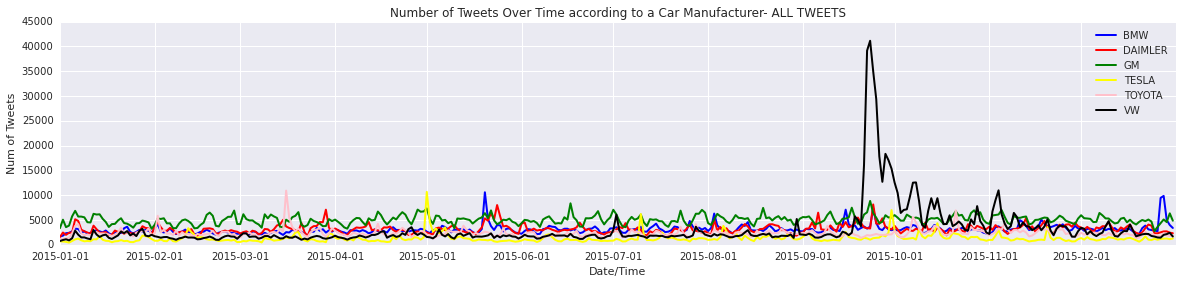

In [24]:
mask_1day = p_df_num_tweets_over_time['POSTING_TIME'].map(lambda x: x.day) == 1
x = p_df_num_tweets_over_time[mask_1day]['POSTING_TIME']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
colors = ['blue', 'red', 'green', 'yellow', 'pink', 'black']
for i in range(0, len(car_makers_name_list)):
    y = car_maker_results_list[i]['COUNT']
    axes.plot(range(len(y)), y, linewidth=2, color=colors[i])
axes.set_xticks(x.index.tolist())
axes.set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes.margins = 0
axes.set_xlabel('Date/Time')
axes.set_ylabel('Num of Tweets')
axes.set_title('Number of Tweets Over Time according to a Car Manufacturer- ALL TWEETS')
axes.set_xlim(0, len(car_maker_results_list[0]))
axes.legend(loc="upper right", labels=car_makers_name_list)
fig.subplots_adjust(hspace=1)
plt.show()

In [25]:
car_maker_results_list = []

### Add sentiment analysis

Next extend your analysis and plot results that combine posting time and sentiment change in tweets in 2015. 
Any positive or negative peaks correspond to events that occurred in the car company at a certain time.

In [26]:
print 'Calculating the number of positive and negative tweets over 2015 for each car maker:'
car_maker_results_list = []
for car_maker in car_makers_name_list:
    #get competitor dataframe
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    
    time_sentiment_car_maker_data = df_car_maker.groupBy('POSTING_TIME', 'SENTIMENT')\
                                        .agg(F.count('MESSAGE_ID').alias('COUNT'))\
                                        .orderBy('POSTING_TIME', ascending=True)
    time_sentiment_car_maker_data.cache()
    time_positive_sentiment_car_maker_data = time_sentiment_car_maker_data.filter(time_sentiment_car_maker_data['SENTIMENT'] == 'POSITIVE')
    time_negative_sentiment_car_maker_data = time_sentiment_car_maker_data.filter(time_sentiment_car_maker_data['SENTIMENT'] == 'NEGATIVE')
    p_time_positive_sentiment_car_maker_data = time_positive_sentiment_car_maker_data.toPandas()
    p_time_negative_sentiment_car_maker_data = time_negative_sentiment_car_maker_data.toPandas()
    car_maker_results_list.append([p_time_positive_sentiment_car_maker_data, p_time_negative_sentiment_car_maker_data])    
    time_sentiment_car_maker_data.unpersist()
    print 'Done for ' + car_maker

Calculating the number of positive and negative tweets over 2015 for each car maker:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


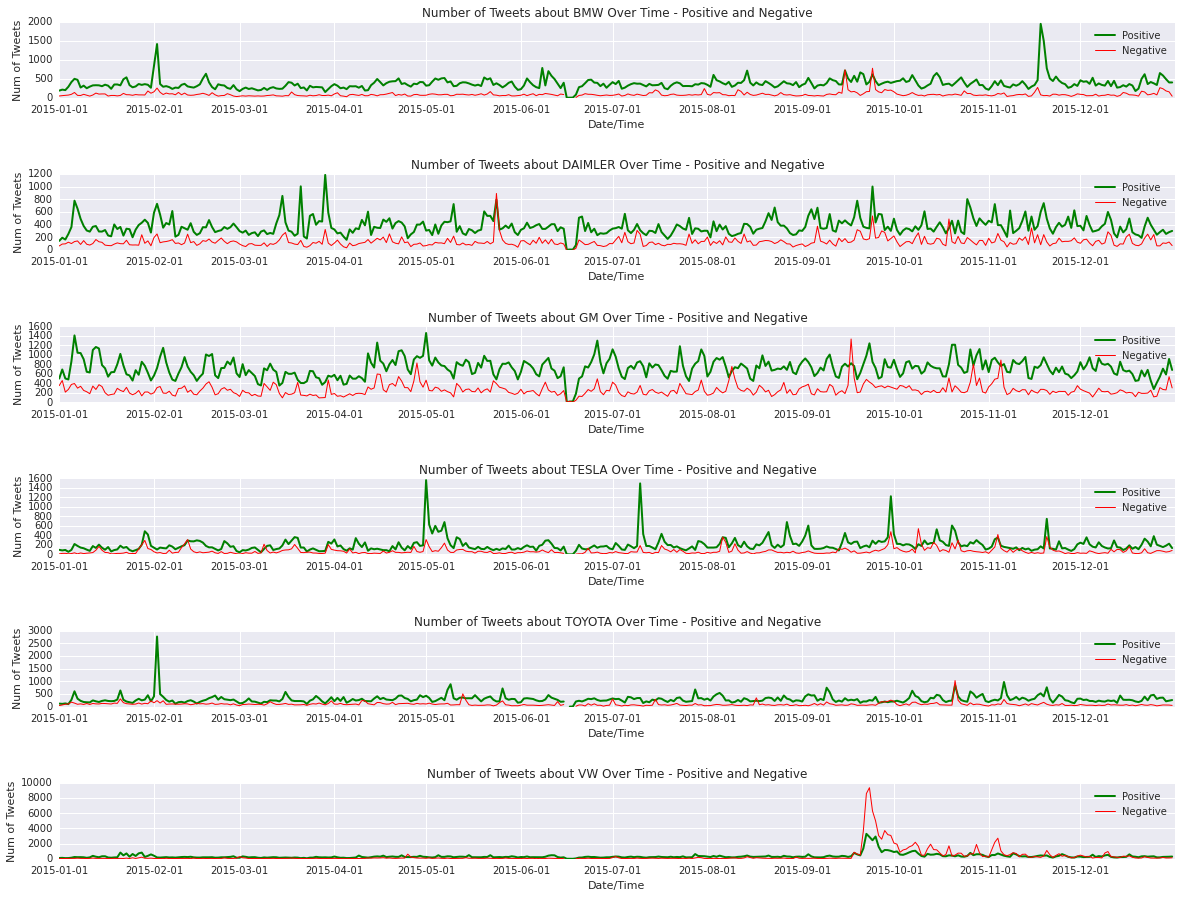

In [27]:
mask_1day = p_df_num_tweets_over_time['POSTING_TIME'].map(lambda x: x.day) == 1
x = p_df_num_tweets_over_time[mask_1day]['POSTING_TIME']
for i in range(0, len(car_makers_name_list)):
    car_maker_results_list[i][0] = addMissingDates(p_df_num_tweets_over_time, car_maker_results_list[i][0])
    car_maker_results_list[i][1] = addMissingDates(p_df_num_tweets_over_time, car_maker_results_list[i][1])
fig, axes = plt.subplots(nrows=len(car_maker_results_list), ncols=1, figsize=(20, 15))
colors = ['blue', 'red', 'green', 'yellow', 'black']
for i in range(0, len(car_makers_name_list)):
    y1 = car_maker_results_list[i][0]['COUNT']
    y2 = car_maker_results_list[i][1]['COUNT']
    axes[i].plot(range(len(y1)), y1, linewidth=2, color='green')
    axes[i].plot(range(len(y2)), y2, linewidth=1, color='red')
    axes[i].set_xticks(x.index.tolist())
    axes[i].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
    axes[i].margins = 0
    axes[i].set_xlabel('Date/Time')
    axes[i].set_ylabel('Num of Tweets')
    axes[i].set_title('Number of Tweets about ' + car_makers_name_list[i] + ' Over Time - Positive and Negative')
    axes[i].set_xlim(0, len(car_maker_results_list[0][0]))
    axes[i].legend(loc="upper right", labels=['Positive', 'Negative'])
fig.subplots_adjust(hspace=1)
plt.show()

### Calculate the number of tweets across car manufacturers

The next code cells calculate the number of tweets about certain car manufacturers and then plot the resulting numbers in a bar chart and as percentages in a pie chart. 

In [28]:
print 'Calculating the number of tweets that mention one of the car makers:'
car_maker_tweets_count = []
for car_maker in car_makers_name_list:
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    car_maker_tweets_count.append(df_car_maker.count())
    print 'Done for ' + car_maker

Calculating the number of tweets that mention one of the car makers:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


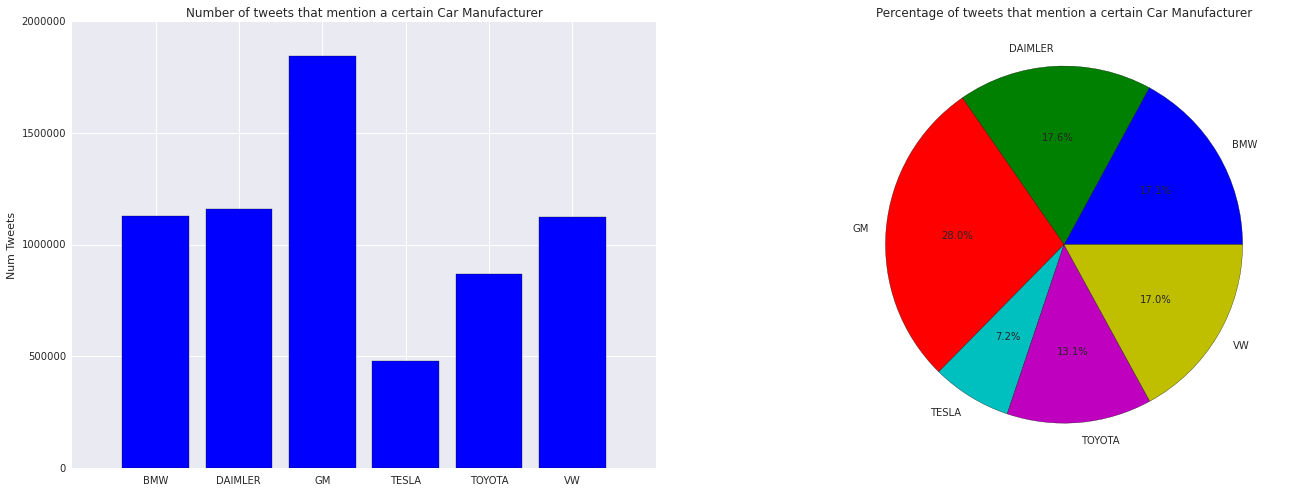

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 8))
axes[0].bar(ind, car_maker_tweets_count, width, color='b', align='center')
axes[0].set_ylabel('Num Tweets')
axes[0].set_title('Number of tweets that mention a certain Car Manufacturer')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(car_makers_name_list)
axes[1].pie(car_maker_tweets_count,autopct='%1.1f%%', labels=car_makers_name_list)
axes[1].set_aspect('equal')
axes[1].set_title('Percentage of tweets that mention a certain Car Manufacturer')
fig.subplots_adjust(hspace=1)
plt.show()

### Calculate the distribution of positive and negative tweets

To determine the distribution of sentiment values of the tweets for each car manufacturer, run the next cell to calculate the number of positive and negative tweets across car makers and plot the results next to each other:

In [30]:
positive_sum_car_makers = []
negative_sum_car_makers = []
for i in range(0, len(car_makers_name_list)):
    car_maker = car_makers_name_list[i]
    car_maker_results_list[i][0] = car_maker_results_list[i][0].fillna(0)
    car_maker_results_list[i][1] = car_maker_results_list[i][1].fillna(0)
    positive_sum_car_makers.extend([sum(car_maker_results_list[i][0]['COUNT'])])
    negative_sum_car_makers.extend([sum(car_maker_results_list[i][1]['COUNT'])])

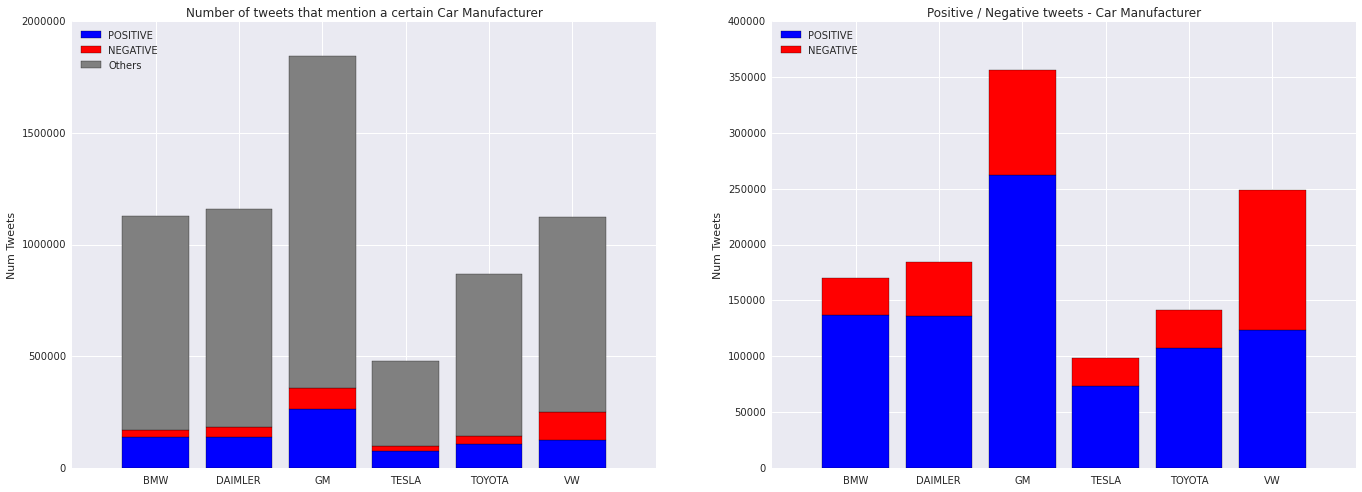

In [31]:
sum_value_P_N = np.add(positive_sum_car_makers, negative_sum_car_makers)
competitors_list_rest = np.subtract(car_maker_tweets_count, sum_value_P_N)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 8))
axes[0].bar(ind, positive_sum_car_makers, width, color='b', align='center')
axes[0].bar(ind, negative_sum_car_makers, width, color='r', bottom=positive_sum_car_makers, align='center')
axes[0].bar(ind, competitors_list_rest, width, color='gray', align='center', bottom=sum_value_P_N)
axes[0].set_ylabel('Num Tweets')
axes[0].set_title('Number of tweets that mention a certain Car Manufacturer')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(car_makers_name_list)
axes[0].legend(loc="upper left", labels=['POSITIVE', 'NEGATIVE', 'Others'])
axes[1].bar(ind, positive_sum_car_makers, width, color='b', align='center')
axes[1].bar(ind, negative_sum_car_makers, width, color='r',
             bottom=positive_sum_car_makers, align='center')
axes[1].set_ylabel('Num Tweets')
axes[1].set_title('Positive / Negative tweets - Car Manufacturer')
axes[1].set_xticks(ind)
axes[1].set_xticklabels(car_makers_name_list)
axes[1].legend(loc="upper left", labels=['POSITIVE', 'NEGATIVE'])
fig.subplots_adjust(hspace=1)
plt.show()

The plots show that in general there are more positive than negative tweets.

### Determine gender distribution 

Another interesting insight when analyzing tweets about certain car manufacturers and what they might want to pay more attention to for marketing purposes is the distribution of tweets between male and female users. 

The following cells calculate the gender distribution across each competitor and plot the results: 

In [32]:
print 'Calculating the distribution of male and female in tweets over 2015 for each competitors:'
car_maker_info_list_M_F = []
for car_maker in car_makers_name_list:
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    car_maker_gender_data = df_car_maker.groupBy('USER_GENDER')\
                                .agg(F.count('MESSAGE_ID').alias('COUNT'))
    car_maker_gender_data.cache()
    p_car_maker_gender_data_male = car_maker_gender_data.filter(car_maker_gender_data['USER_GENDER'] == 'male').toPandas()
    p_car_maker_gender_data_female = car_maker_gender_data.filter(car_maker_gender_data['USER_GENDER'] == 'female').toPandas()
    car_maker_info_list_M_F.append([p_car_maker_gender_data_male, p_car_maker_gender_data_female])
    car_maker_gender_data.unpersist()
    print 'Done for ' + car_maker

Calculating the distribution of male and female in tweets over 2015 for each competitors:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


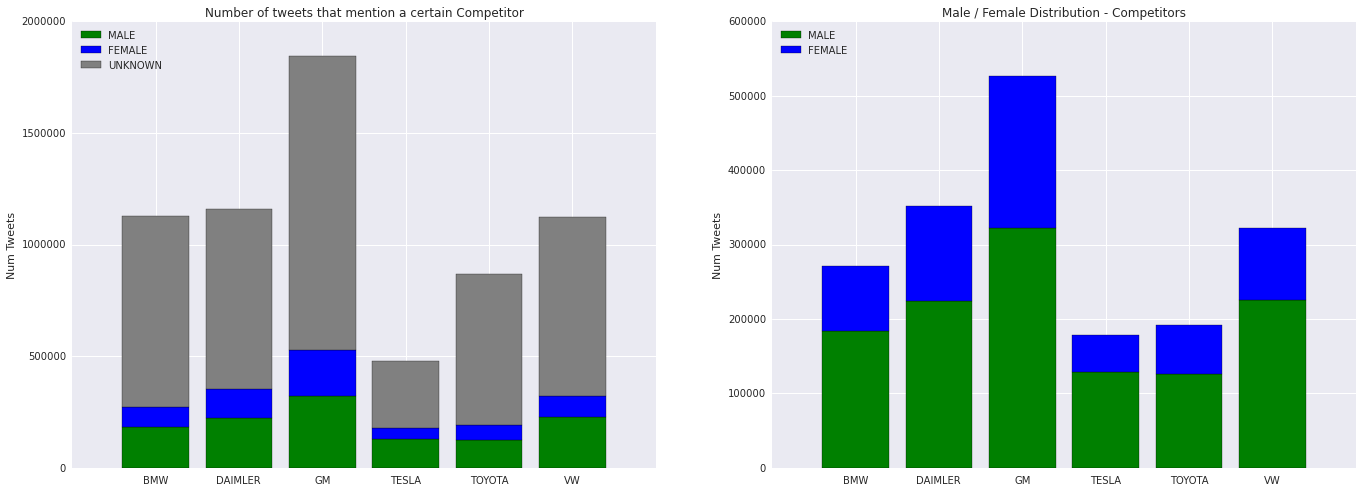

In [33]:
car_maker_list_female = []
car_maker_list_male = []
for i in range(0, len(car_maker_info_list_M_F)):
    car_maker_list_female.append(car_maker_info_list_M_F[i][1]['COUNT'][0])
    car_maker_list_male.append(car_maker_info_list_M_F[i][0]['COUNT'][0])
sum_value_M_F = np.add(car_maker_list_male, car_maker_list_female)
car_maker_list_M_F_rest = np.subtract(car_maker_tweets_count, sum_value_M_F)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 8))
axes[0].bar(ind, car_maker_list_male, width, color='g', align='center')
axes[0].bar(ind, car_maker_list_female, width, color='b', bottom=car_maker_list_male, align='center')
axes[0].bar(ind, car_maker_list_M_F_rest, width, color='gray', align='center', bottom=sum_value_M_F)
axes[0].set_ylabel('Num Tweets')
axes[0].set_title('Number of tweets that mention a certain Competitor')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(car_makers_name_list)
axes[0].legend(loc="upper left", labels=['MALE', 'FEMALE', 'UNKNOWN'])
axes[1].bar(ind, car_maker_list_male, width, color='g', align='center')
axes[1].bar(ind, car_maker_list_female, width, color='b', bottom=car_maker_list_male, align='center')
axes[1].set_ylabel('Num Tweets')
axes[1].set_title('Male / Female Distribution - Competitors')
axes[1].set_xticks(ind)
axes[1].set_xticklabels(car_makers_name_list)
axes[1].legend(loc="upper left", labels=['MALE', 'FEMALE'])
fig.subplots_adjust(hspace=1)
plt.show()

The plotted results show that, in general, men post more tweets about cars than women do.

### Measure influence

In this section, you will calculate the social influence of people who tweeted about a certain car manufacturer. The average influence variable is calculated by: 

$$Influence = ( \space num \space of \space followers + \space number \space of \space friends \space ) \div 2$$

The influence score shows whether someone is a famous person, a public figure in society, or whether the twitter account is owned by the media or a company. This average shows who is interested in a certain car maker.

In [34]:
def getInsights_Influence(sparkDF, car_maker_list):
    print 'Calculating the influence insight of the users in tweets over 2015 for each competitors:'
    car_maker_result_list = []
    for car_maker in car_maker_list:
        df_car_maker = sparkDF.filter(sparkDF[car_maker] == True)
        car_maker_insight_data = df_car_maker.select(F.avg('INFLUENCE').alias('AVE_INFLUENCE'))
        car_maker_result_list.append(car_maker_insight_data.toPandas())
        df_car_maker.unpersist()
        car_maker_insight_data.unpersist()
        print 'Done for ' + car_maker
    return car_maker_result_list

In [35]:
influenceInsights = getInsights_Influence(df_tweets_car_maker, car_makers_name_list)

Calculating the influence insight of the users in tweets over 2015 for each competitors:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


In [36]:
influence_list = []
for i in range(0, len(car_makers_name_list)):
    influence_list.append(influenceInsights[i]['AVE_INFLUENCE'][0])

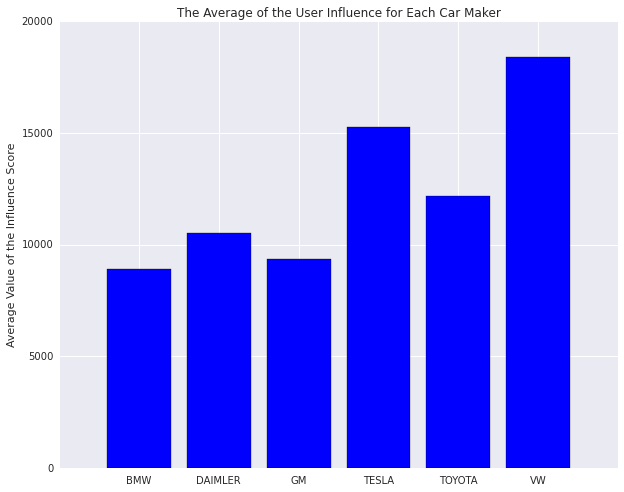

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
rects = axes.bar(ind, influence_list, width, color='b', align='center')
axes.set_ylabel('Average Value of the Influence Score')
axes.set_title('The Average of the User Influence for Each Car Maker')
axes.set_xticks(ind)
axes.set_xticklabels(car_makers_name_list)
fig.subplots_adjust(hspace=1)
plt.show()

In [38]:
influenceInsights = None

### Determine the distribution of tweets about car manufacturers by country

The next cells identify the countries where the most tweets were posted about car manufacturers. This information can support marketing and sales representatives when evaluating potential customers.

In [39]:
print 'Calculating the country distribution of tweets over 2015 for each car maker:'
car_maker_info_list_countries = []
for car_maker in car_makers_name_list:
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    car_maker_country_data = df_car_maker.groupBy('USER_COUNTRY')\
                                .agg(F.count('MESSAGE_ID').alias('COUNT'))\
                                .orderBy('COUNT', ascending=False)
    car_maker_country_data.cache()
    p_car_maker_country_data = car_maker_country_data.toPandas()
    car_maker_info_list_countries.append(p_car_maker_country_data)
    car_maker_country_data.unpersist()
    print 'Done for ' + car_maker

Calculating the country distribution of tweets over 2015 for each car maker:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


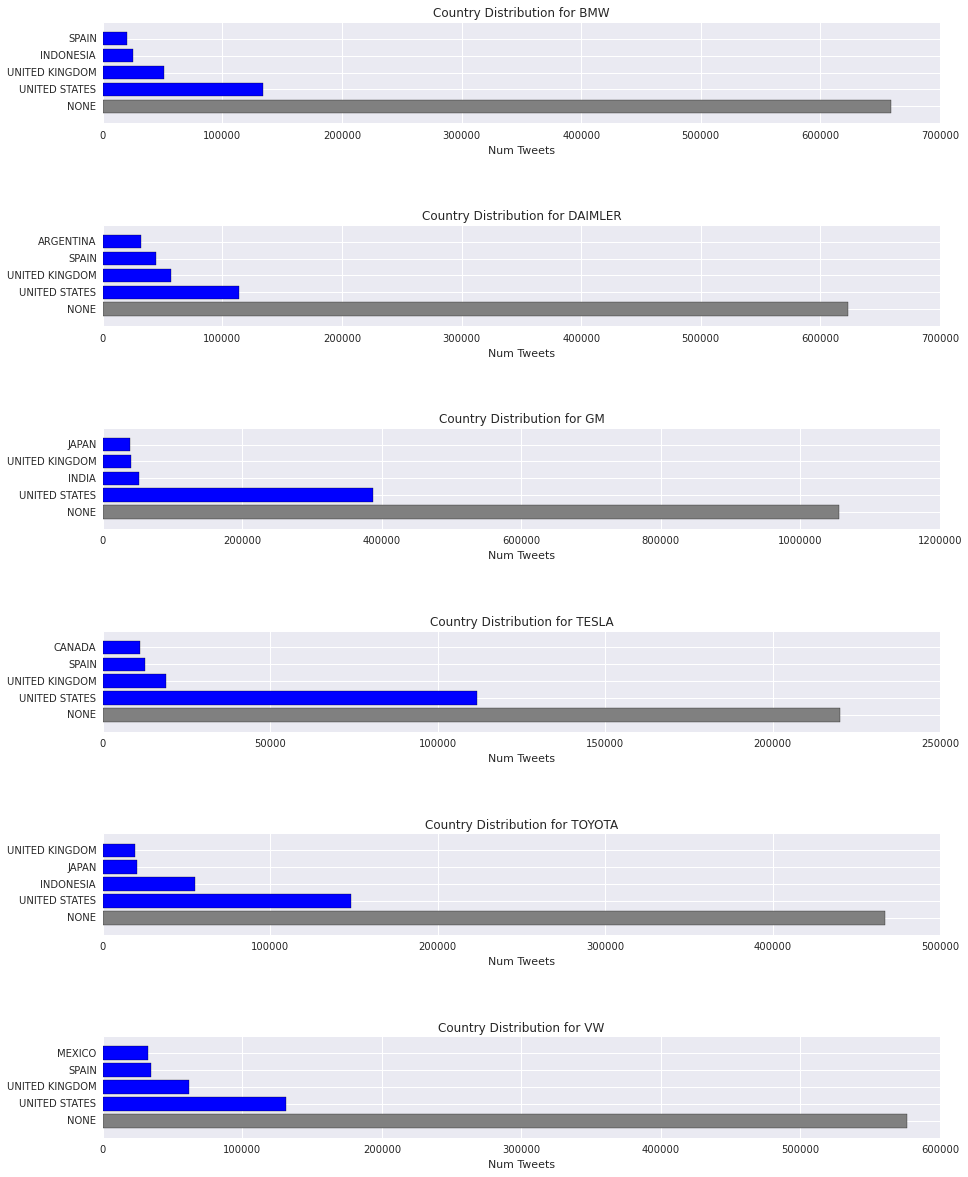

In [40]:
num_taken_countries = 5
fig, axes = plt.subplots(nrows=len(car_makers_name_list), ncols=1, figsize=(15, 20))
for j in range(0, len(car_makers_name_list)):
    color = 'b'
    colors = np.repeat(color, num_taken_countries).tolist()
    country_list_num = car_maker_info_list_countries[j]['COUNT'][:num_taken_countries]
    country_list_labels = car_maker_info_list_countries[j]['USER_COUNTRY'][:num_taken_countries]
    for counter in range(0, len(country_list_labels)):
        if (country_list_labels[counter] == 'NONE'):
            colors[counter] = 'gray'
    axes[j].barh(np.arange(num_taken_countries), country_list_num, width, color=colors, align='center')
    axes[j].set_xlabel('Num Tweets')
    axes[j].set_title('Country Distribution for ' + car_makers_name_list[j])
    axes[j].set_yticks(ind)
    axes[j].set_yticklabels(country_list_labels.tolist())
fig.subplots_adjust(hspace=1)
plt.show()

The previous plots show the countries with the highest number of tweets about one car maker. You can also calculate the distribution of tweets about all of the car makers for one country and compare countries. Run the following cells to compare these results for the US, UK and Germany:

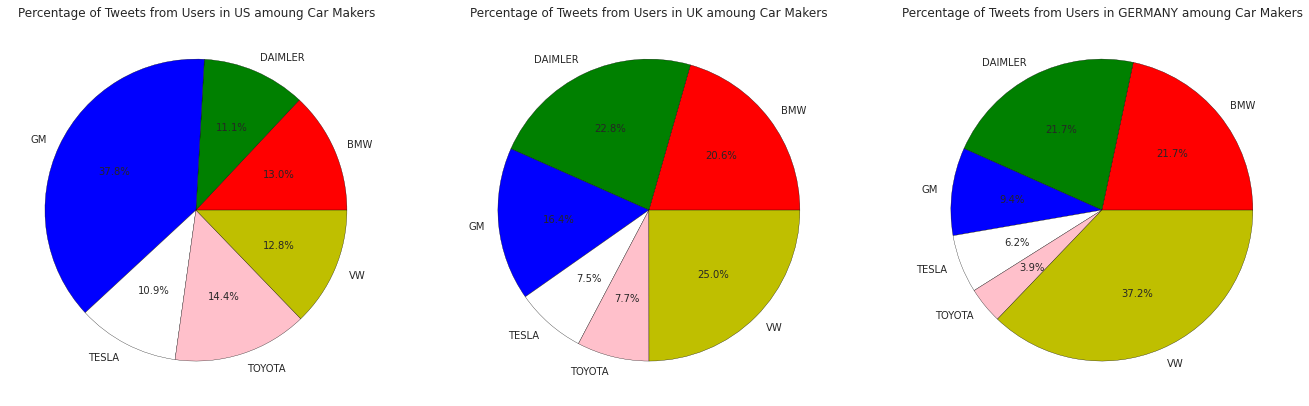

In [63]:
us_list = []
uk_list = []
de_list = []
for i in range(0, len(car_makers_name_list)):
    x = car_maker_info_list_countries[i]
    us_list.extend([x[x['USER_COUNTRY'] == 'UNITED STATES']['COUNT'].tolist()[0]])
    uk_list.extend([x[x['USER_COUNTRY'] == 'UNITED KINGDOM']['COUNT'].tolist()[0]])
    de_list.extend([x[x['USER_COUNTRY'] == 'GERMANY']['COUNT'].tolist()[0]])
colors = ['r', 'g', 'b', 'w', 'pink', 'y']
us_values = us_list
uk_values = uk_list
de_values = de_list

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 10))
axes[0].pie(us_values,autopct='%1.1f%%', colors=colors, labels=car_makers_name_list)
axes[0].set_aspect('equal')
axes[0].set_title('Percentage of Tweets from Users in US amoung Car Makers')
axes[1].pie(uk_values,autopct='%1.1f%%', colors=colors, labels=car_makers_name_list)
axes[1].set_aspect('equal')
axes[1].set_title('Percentage of Tweets from Users in UK amoung Car Makers')
axes[2].pie(de_values,autopct='%1.1f%%', colors=colors, labels=car_makers_name_list)
axes[2].set_aspect('equal')
axes[2].set_title('Percentage of Tweets from Users in GERMANY amoung Car Makers')
fig.subplots_adjust(hspace=1)
plt.show()

<a id="drawinsightsaboutfeatures"> </a>
##  Draw insights about car features

In this section, you will analyze the data set to extract insights about car features, for example, information about electric cars and self-driving cars.

### Helper functions

Begin by defining the functions that you'll be using in your analysis to determine and plot gender and country distribution values in tweets about electric and self-driving cars: 

In [42]:
def getCountryDistribution(df):
    df_cleaned_tweets_countries = df.groupBy('USER_COUNTRY')\
                .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))\
                .orderBy('NUM_TWEETS', ascending=False)
    return df_cleaned_tweets_countries.toPandas()

def PlotCountryDistribution(pdf, num_plotted_countries, title):
    countries = pdf['USER_COUNTRY'][:num_plotted_countries]
    num_tweets = pdf['NUM_TWEETS'][:num_plotted_countries]
    y_pos = np.arange(len(countries))
    colors = np.repeat('b', num_plotted_countries - 1).tolist()
    colors = ['gray'] + colors
    plt.figure(figsize=(10,8))
    plt.barh(y_pos, num_tweets, align='center', color=colors)
    plt.yticks(y_pos, countries)
    plt.xlabel('Number of Tweets')
    plt.title(title)
    plt.ylim(-1, len(y_pos))
    plt.show()

#sentiment functions
#the dataframe should have the columns Sentiment, MESSAGE_ID
def getGeneralSentiment(df):
    df_grouped_by_sentiment = df\
                            .groupBy('SENTIMENT')\
                            .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))
    return df_grouped_by_sentiment.toPandas()


#it returns a list which contains a sequence of element. Each element is a list of integer values. Those values are:
#total count, male count, female count, positive count, negative count
def getCarMaker_Gender_Sentiment_Analysis(df):
    final_result_list = []
    for car_maker in car_makers_name_list:
        result_carMaker_list = []
        df_car_maker = df.filter(df[car_maker] == True)
        result_carMaker_list.append(df_car_maker.count())#total count for a car maker
        df_car_maker_male = df_car_maker.filter(df.USER_GENDER == 'male')
        result_carMaker_list.append(df_car_maker_male.count())#male count
        df_car_maker_female = df_car_maker.filter(df.USER_GENDER == 'female')
        result_carMaker_list.append(df_car_maker_female.count())#female count
        df_car_maker_male.unpersist()
        df_car_maker_female.unpersist()
        df_sentiment = df_car_maker.groupBy('SENTIMENT')\
                            .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))
        result_carMaker_list.append(df_sentiment.toPandas())#positive count
        df_sentiment.unpersist()
        final_result_list.append(result_carMaker_list)
        print 'Done calculation for ' + car_maker
    return final_result_list

def BarPlot(axes, values, title, ytitle, xlabels):
    rects = axes.bar(ind, values, width, color='b', align='center')
    axes.set_ylabel(ytitle)
    axes.set_title(title)
    axes.set_xticks(ind)
    axes.set_xticklabels(xlabels)

def getPercentag(total, portion):
    return (portion*100) / total

def getMaleFemaleDistribution(df):
    df_grouped_by_gender = df\
            .groupBy('USER_GENDER')\
            .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))
    return df_grouped_by_gender.toPandas()

def Plot_PieChart(pdf, labels_column, values_column, axes, title, plot1_colors):
    plot1_labels = map(lambda x:str(x).upper(), pdf[labels_column])
    plot1_values = pdf[values_column]
    axes.pie(plot1_values,  labels=plot1_labels, colors=plot1_colors, autopct='%1.1f%%')
    axes.set_title(title)
    axes.set_aspect('equal')
    axes.legend(loc="upper right", labels=plot1_labels)
    
#data_list: data to plot has the strucutre: [[list values 1], [list values 2], [list values 3]]
def plotHorBarPercentage(axes, data_list, title_string, xtitle, ylabels, color_list, legend_labels):
    y_pos = np.arange(len(data_list[0]))
    for i in range(0, len(data_list)):
        if (i == 0):
            rects = axes.barh(y_pos, data_list[i], align='center', color=color_list[i])
            counter = 0
            for rect in rects:
                axes.text(rect.get_width()/2., rect.get_y() + rect.get_height()/3., '%.1f' % data_list[i][counter] + '%', ha='center', va='bottom')
                counter += 1
        else:
            old_value = np.zeros(len(data_list[0])).tolist()
            for j in range(0, i):
                old_value = [sum(x) for x in zip(old_value, data_list[j])]
            rects = axes.barh(y_pos, data_list[i], align='center', color=color_list[i], left=old_value)
            counter = 0
            for rect in rects:
                axes.text(rect.get_width()/2. + rect.get_x(), rect.get_y() + rect.get_height()/3., '%.1f' % data_list[i][counter] + '%', ha='center', va='bottom')
                counter += 1
    axes.set_yticks(y_pos)
    axes.set_yticklabels(ylabels)
    axes.set_xlabel(xtitle)
    axes.set_title(title_string)
    axes.set_ylim(-1, len(y_pos))
    axes.set_xlim(0, 100)
    axes.legend(loc="upper center", labels=legend_labels, ncol=len(legend_labels))

### Draw insights about electric cars

Some customers are looking to buy an electric vehicle to help save gasoline and protect the environment. For this reason, many car manufacturers have moved to producing electric cars. In this section, you will learn how to analyze tweets, which mention electric cars. 

To find these tweets, you need to search for certain words inside the tweet text such as *electric cars*, *electric motors*, and so on. The sample uses the search terms in the list called `electric_vehicle_terms` to find matches. The list contains terms in English, French, German, and Spanish.

In this section, you will use the constructed DataFrame called `df_tweets_car_maker`. This DataFrame has a column named ELECTRIC_CARS which indicates whether electric cars were mentioned in a tweet or not. Run the next cell to filter the data according to the value in this column:

In [43]:
df_electric_cars = df_tweets_car_maker.filter(df_tweets_car_maker.ELECTRIC_CARS == True)
df_electric_cars.cache()

DataFrame[MESSAGE_ID: string, MESSAGE_BODY: string, SENTIMENT: string, USER_GENDER: string, USER_COUNTRY: string, POSTING_TIME: timestamp, IS_PARENT: string, IS_MARRIED: string, INFLUENCE: double, BMW: boolean, DAIMLER: boolean, GM: boolean, TESLA: boolean, TOYOTA: boolean, VW: boolean, ELECTRIC_CARS: boolean, AUTO_DRIVE: boolean]

The next cell calculates the number of tweets that mention electic cars:

In [44]:
df_electric_cars.count()

23509

### Calculate the country distribution of electric car tweets

In this section, you will find the top ten countries with the highest number of tweets about electric cars. 
<br>
Run the next cell to build a pandas DataFrame that contains the data about the country distribution. The computation calls  the `getCountryDistribution` helper function:

In [45]:
p_electric_cars_countries = getCountryDistribution(df_electric_cars)

The following cell plots the country distribution by calling the `PlotCountryDistribution` helper function:

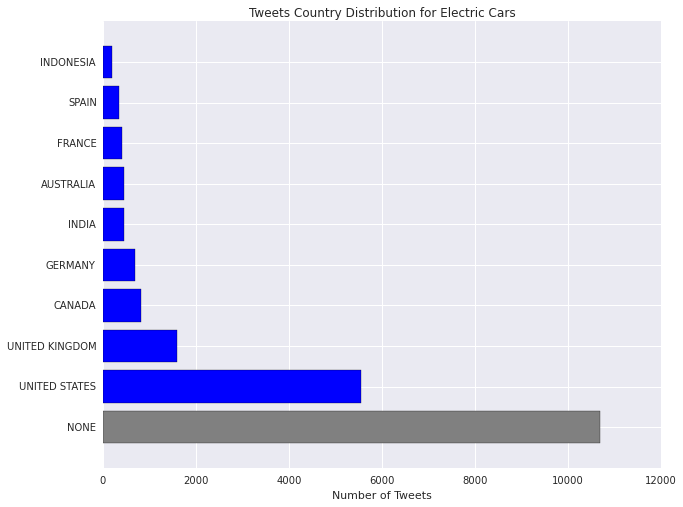

In [46]:
PlotCountryDistribution(p_electric_cars_countries, 10, 'Tweets Country Distribution for Electric Cars')

### Extract sentiment and gender information from tweets about electric cars

The next cell collects sentiment information by calling the `getGeneralSentiment` function. The function returns a pandas DataFrame that contains the DataFrame regrouped by sentiment values and aggregated by the count function to get the number of tweets for each type of sentiment. 

In [47]:
p_electric_cars_general_sentiment = getGeneralSentiment(df_electric_cars)

The next cell collects information about the gender distribution in tweets in the data set by calling the  `getMaleFemaleDistribution` function. This function groups the data by the USER_GENDER value and then counts the number of tweets in each group.

In [48]:
p_electric_cars_gender_distribution = getMaleFemaleDistribution(df_electric_cars)

Run the next cell to collect insights about electric cars in tweets related to the six car makers you are analyzing and to extract the gender and sentiment information from these tweets:

In [49]:
print 'Calculating the electric car sentiment for each car maker:'
electric_cars_carMakers_results = getCarMaker_Gender_Sentiment_Analysis(df_electric_cars)

Calculating the electric car sentiment for each car maker:
Done calculation for BMW
Done calculation for DAIMLER
Done calculation for GM
Done calculation for TESLA
Done calculation for TOYOTA
Done calculation for VW


Now that the information that you need is in a pandas DataFrame, run the next cell to plot the number of tweets about electric cars across the six car manufacturers in the data set:

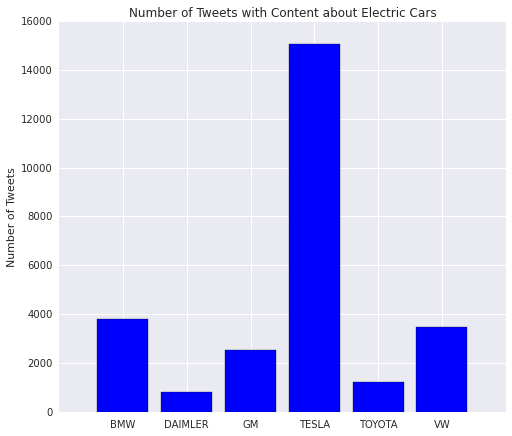

In [50]:
total_num_tweets = []
for data_car_maker in electric_cars_carMakers_results:
    total_num_tweets.append(data_car_maker[0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
BarPlot(axes, total_num_tweets, 'Number of Tweets with Content about Electric Cars', 'Number of Tweets', car_makers_name_list)
plt.show()

### Sentiment analysis for the electric cars tweets

Run the next cell to first plot the general distribution of sentiment values in the electric cars DataFrame and then to plot the distribution of these values across car makers:

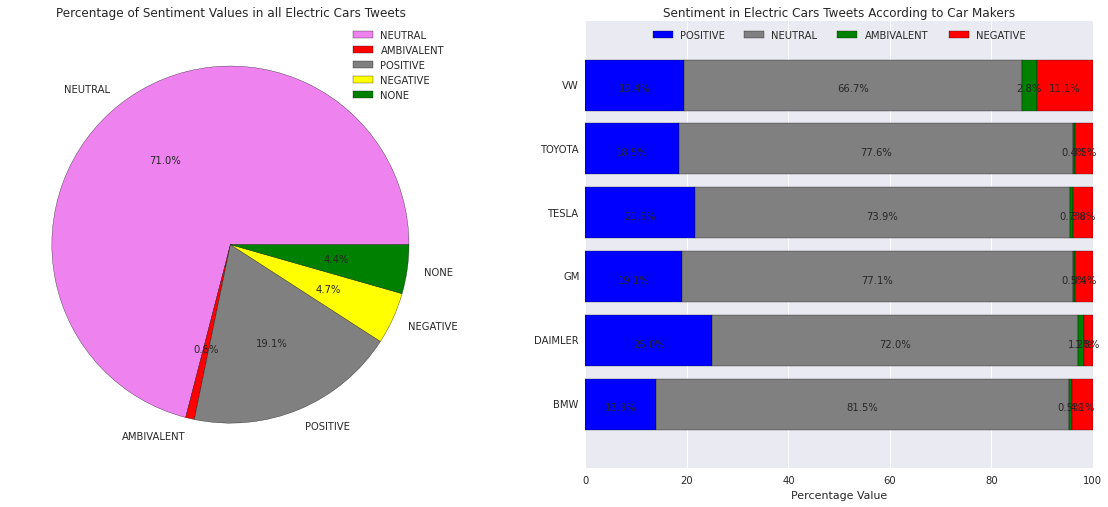

In [51]:
def getSentimentValueFromDataList(data_list, filter):
    x = data_list[3]['NUM_TWEETS'][filter].tolist()
    if (len(x) > 0):
        return x[0]
    else:
        return 0

Positive_percentage_list = []
Negative_percentage_list = []
Ambivalent_percentage_list = []
Neutral_percentage_list = []
for data_car_maker in electric_cars_carMakers_results:
    positive_filter = data_car_maker[3]['SENTIMENT'] == 'POSITIVE'
    negative_filter = data_car_maker[3]['SENTIMENT'] == 'NEGATIVE'
    neutral_filter = data_car_maker[3]['SENTIMENT'] == 'NEUTRAL'
    ambivalent_filter = data_car_maker[3]['SENTIMENT'] == 'AMBIVALENT'
    positive_num_tweets = getSentimentValueFromDataList(data_car_maker, positive_filter)
    negative_num_tweets = getSentimentValueFromDataList(data_car_maker, negative_filter)
    neutral_num_tweets = getSentimentValueFromDataList(data_car_maker, neutral_filter)
    ambivalent_num_tweets = getSentimentValueFromDataList(data_car_maker, ambivalent_filter)
    total_num_tweets_with_sentiment = positive_num_tweets + negative_num_tweets + neutral_num_tweets + ambivalent_num_tweets
    Positive_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, positive_num_tweets))
    Negative_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, negative_num_tweets))
    Ambivalent_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, ambivalent_num_tweets))
    Neutral_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, neutral_num_tweets))
print_list = [Positive_percentage_list, Neutral_percentage_list, Ambivalent_percentage_list, Negative_percentage_list]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
Plot_PieChart(p_electric_cars_general_sentiment, 'SENTIMENT', 'NUM_TWEETS',  axes[0], 'Percentage of Sentiment Values in all Electric Cars Tweets', ['Violet', 'red', 'gray', 'yellow', 'green'])
plotHorBarPercentage(axes[1], print_list, 'Sentiment in Electric Cars Tweets According to Car Makers', 
                     'Percentage Value', car_makers_name_list, ['b', 'gray', 'green', 'red'], ['POSITIVE', 'NEUTRAL', 'AMBIVALENT', 'NEGATIVE'])
fig.subplots_adjust(hspace=1)
plt.show()

### Calculate the gender distribution of electric car tweets

The next cell plots the distribution of gender in the electric cars DataFrame and then plots the distribution of these values across the six car makers.

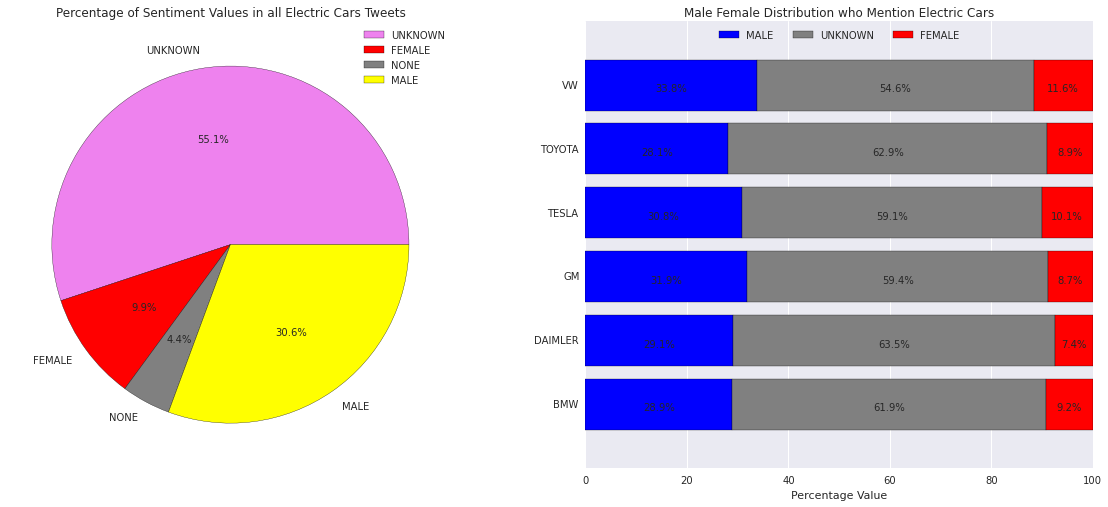

In [52]:
male_percentage_list = []
female_percentage_list = []
rest_percentage_list = []
for data_car_maker in electric_cars_carMakers_results:
    male_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[1]))
    female_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[2]))
    rest_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[0] - (data_car_maker[1] + data_car_maker[2])))
print_list = [male_percentage_list, rest_percentage_list, female_percentage_list]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
Plot_PieChart(p_electric_cars_gender_distribution, 'USER_GENDER', 'NUM_TWEETS', axes[0], 'Percentage of Sentiment Values in all Electric Cars Tweets', ['Violet', 'red', 'gray', 'yellow', 'green'])
plotHorBarPercentage(axes[1], print_list, 'Male Female Distribution who Mention Electric Cars', 'Percentage Value', car_makers_name_list, ['b', 'gray', 'red'], ['MALE', 'UNKNOWN', 'FEMALE'])
plt.show()

### Self-driving cars

In this section, you will perform an analysis to extract insights about self-driving cars from tweets in the data set. To find these tweets, you need to search for words like *self-driving cars*, *autodrive cars*, *robot cars*, and so on. The sample uses the search terms in the list called `df_tweets_car_maker` to find matches. The list contains terms in English, French, German, and Spanish.


In this section, you will use the constructed DataFrame called `df_tweets_car_maker`. This DataFrame has a column named AUTO_DRIVE which indicates whether self-driving cars were mentioned in a tweet or not. Run the next cell to filter the data according to the value of this column.

In [53]:
df_autodrive = df_tweets_car_maker.filter(df_tweets_car_maker.AUTO_DRIVE == True)
df_autodrive.cache()

DataFrame[MESSAGE_ID: string, MESSAGE_BODY: string, SENTIMENT: string, USER_GENDER: string, USER_COUNTRY: string, POSTING_TIME: timestamp, IS_PARENT: string, IS_MARRIED: string, INFLUENCE: double, BMW: boolean, DAIMLER: boolean, GM: boolean, TESLA: boolean, TOYOTA: boolean, VW: boolean, ELECTRIC_CARS: boolean, AUTO_DRIVE: boolean]

Run the next cell to calculate the number of tweets that mention self-driving cars in the data set:

In [54]:
df_autodrive.count()

17623

#### Calculate the country distribution of tweets about self-driving cars

In this section, you will find the top ten countries with the highest number of tweets about self-driving cars. 
<br>

Run the next cell to build a pandas DataFrame that contains the data about the country distribution for tweets about self-driving cars. The computation calls the `getCountryDistribution` helper function.

In [55]:
p_autodrive_countries = getCountryDistribution(df_autodrive)

Run the next cell to plot the country distribution by calling the `PlotCountryDistribution` helper function:

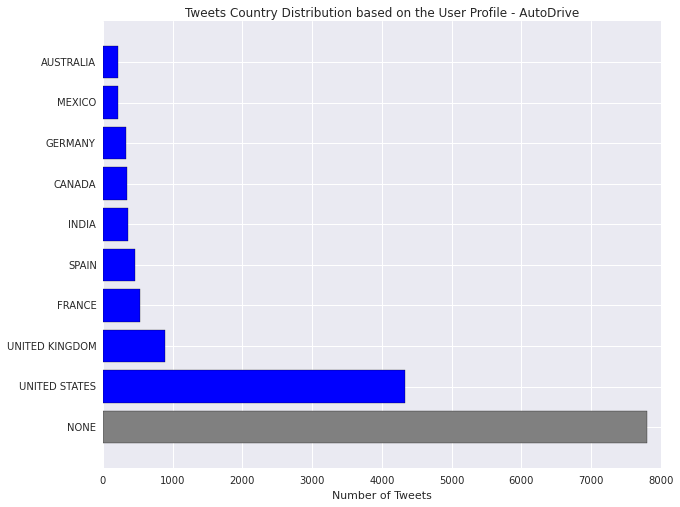

In [56]:
PlotCountryDistribution(p_autodrive_countries, 10, 'Tweets Country Distribution based on the User Profile - AutoDrive')

#### Extract sentiment and gender information from tweets about self-driving cars

Run the next cell to collect sentiment information by calling the `getGeneralSentiment` helper function. The function returns a pandas DataFrame that contains the DataFrame regrouped by sentiment values and aggregated by the count function to get the number of tweets for each type of sentiment.

In [57]:
p_autodrive_general_sentiment = getGeneralSentiment(df_autodrive)

Run the next cell to collect information about the gender distribution in tweets about self-driving cars by calling the `getMaleFemaleDistribution` function. This function groups the data by the USER_GENDER value and then counts the number of tweets in each group.

In [58]:
p_autodrive_gender_distribution = getMaleFemaleDistribution(df_autodrive)

Run the next cell to collect insights about self-driving cars in tweets related to the six car makers and to extract the gender and sentiment information from these tweets:

In [59]:
print 'Calculating the autodrive car sentiment for each car maker:'
auto_drive_carMakers_results = getCarMaker_Gender_Sentiment_Analysis(df_autodrive)

Calculating the autodrive car sentiment for each car maker:
Done calculation for BMW
Done calculation for DAIMLER
Done calculation for GM
Done calculation for TESLA
Done calculation for TOYOTA
Done calculation for VW


Now that the information that you need is in a pandas DataFrame, run the next cell to plot the number of tweets about self-driving cars across the six car manufacturers in the data set:

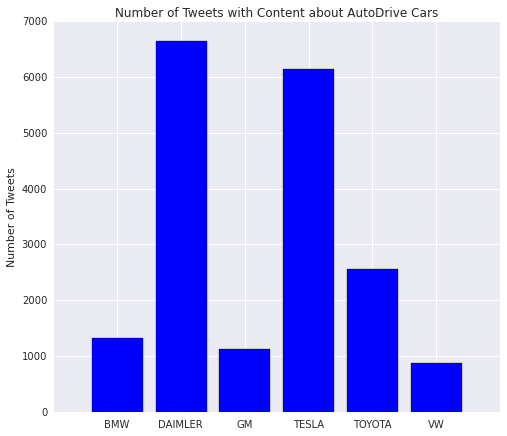

In [60]:
total_num_tweets = []
for data_car_maker in auto_drive_carMakers_results:
    total_num_tweets.append(data_car_maker[0])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
BarPlot(axes, total_num_tweets, 'Number of Tweets with Content about AutoDrive Cars', 'Number of Tweets', car_makers_name_list)
plt.show()

#### Sentiment analysis in tweets about self-driving cars

Run the next cell to plot the general distribution of sentiment values in the autodriving cars DataFrame and then to plot the distribution of these values across car makers:

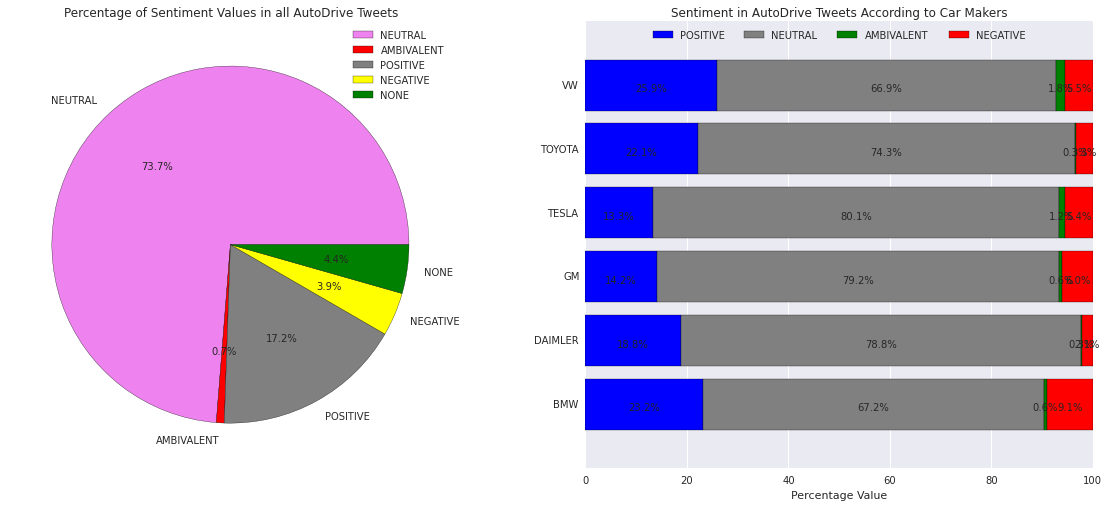

In [61]:
def getSentimentValueFromDataList(data_list, filter):
    x = data_list[3]['NUM_TWEETS'][filter].tolist()
    if (len(x) > 0):
        return x[0]
    else:
        return 0

Positive_percentage_list = []
Negative_percentage_list = []
Ambivalent_percentage_list = []
Neutral_percentage_list = []
for data_car_maker in auto_drive_carMakers_results:
    positive_filter = data_car_maker[3]['SENTIMENT'] == 'POSITIVE'
    negative_filter = data_car_maker[3]['SENTIMENT'] == 'NEGATIVE'
    neutral_filter = data_car_maker[3]['SENTIMENT'] == 'NEUTRAL'
    ambivalent_filter = data_car_maker[3]['SENTIMENT'] == 'AMBIVALENT'
    positive_num_tweets = getSentimentValueFromDataList(data_car_maker, positive_filter)
    negative_num_tweets = getSentimentValueFromDataList(data_car_maker, negative_filter)
    neutral_num_tweets = getSentimentValueFromDataList(data_car_maker, neutral_filter)
    ambivalent_num_tweets = getSentimentValueFromDataList(data_car_maker, ambivalent_filter)
    total_num_tweets_with_sentiment = positive_num_tweets + negative_num_tweets + neutral_num_tweets + ambivalent_num_tweets
    Positive_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, positive_num_tweets))
    Negative_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, negative_num_tweets))
    Ambivalent_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, ambivalent_num_tweets))
    Neutral_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, neutral_num_tweets))
print_list = [Positive_percentage_list, Neutral_percentage_list, Ambivalent_percentage_list, Negative_percentage_list]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
Plot_PieChart(p_autodrive_general_sentiment, 'SENTIMENT', 'NUM_TWEETS',  axes[0], 'Percentage of Sentiment Values in all AutoDrive Tweets',\
                     ['Violet', 'red', 'gray', 'yellow', 'green'])
plotHorBarPercentage(axes[1], print_list, 'Sentiment in AutoDrive Tweets According to Car Makers', 'Percentage Value', car_makers_name_list, ['b', 'gray', 'green', 'red'], ['POSITIVE', 'NEUTRAL', 'AMBIVALENT', 'NEGATIVE'])
fig.subplots_adjust(hspace=1)
plt.show()

#### Calculate the gender distribution in tweets about self-driveing cars

The next cell plots the distribution of gender in the autodriving cars DataFrame and then plots the distribution of these values across car makers.

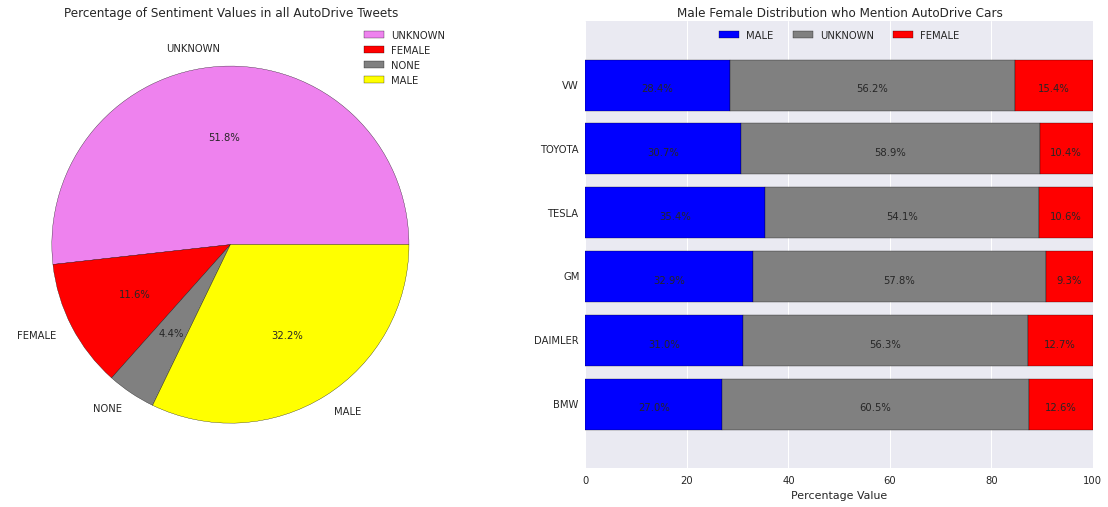

In [62]:
male_percentage_list = []
female_percentage_list = []
rest_percentage_list = []
for data_car_maker in auto_drive_carMakers_results:
    male_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[1]))
    female_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[2]))
    rest_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[0] - (data_car_maker[1] + data_car_maker[2])))
print_list = [male_percentage_list, rest_percentage_list, female_percentage_list]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
Plot_PieChart(p_autodrive_gender_distribution, 'USER_GENDER', 'NUM_TWEETS', axes[0], 'Percentage of Sentiment Values in all AutoDrive Tweets', ['Violet', 'red', 'gray', 'yellow', 'green'])
plotHorBarPercentage(axes[1], print_list, 'Male Female Distribution who Mention AutoDrive Cars', 'Percentage Value', car_makers_name_list, ['b', 'gray', 'red'], ['MALE', 'UNKNOWN', 'FEMALE'])
plt.show()

<a id="summary"> </a>
## Summary

In this notebook, you learned how to use notebooks to analyze Twitter data and extract interesting insights from tweets. You learned how to easily perform complex computations on a large amount of data in a notebook by using SparkContext, how to integrate data from dashDB by using the Spark connector, and how to use Spark and pandas DataFrames.

Copyright © IBM Corp. 2016, 2017. This notebook and its source code are released under the terms of the MIT License.